# Brainer V1
## Finds the best artificial brain for your data!

In [1]:
import numpy
import pandas
import tensorflow
from tensorflow import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, r2_score
from tensorflow.python.client import device_lib

%matplotlib inline

### Check GPU

In [2]:
tensorflow.config.list_physical_devices('GPU')

[]

## Brainer Parameters

In [3]:
lucky_number = 32 # Control Numpy & Tensorflow's Pseudonumber Generator

# Cube Object Process Data and Stores X, Y, scalers and folding objects
cube_json = {
    'filename' : 'iris.data',
    'sep' : ',',
    'decimal' : '.',
    'features' : {'petallength' : 'float',
                  'petalwidth' : 'float',
                  'sepallength' : 'float',
                  'sepalwidth' : 'float',
                  'flower' : 'str'},
    'regressand' : 'petallength',
    'sampler' : 'flower',
    'lucky_number' : lucky_number,
    'folds' : 20,
    'bad_folds' : 1
 }

brainer_json = {
    'scorer' : 'mse',
    'learning_rate' : 0.01,
    'activations' : ['linear', 'relu', 'tanh'],
    'optimizers' : ['adagrad', 'adam'],
    'patience' : 32,
    'epochs_per_patience' : 32,
    'neuron_gain' : 0.01,
    'fold_gain' : 0.01,
    'max_layers' : 3,
    'max_neurons_per_layer' : 7,
    'relevant_features' : 3,
    'rollback_on_no_bound_gain' : True,
    'print_anyway' : True
}

### Get Lucky

In [4]:
# SET THE RANDOM SEED
numpy.random.seed(lucky_number)
tensorflow.random.set_seed(lucky_number)

### Config Class

In [5]:
from typing import Any

class Config(dict):
    def __init__(self, configs : dict):
        for config in configs:
            self[config] = configs[config]
    
    def __getattr__(self, __name):
        if __name in self:
            return self[__name]

    def __setattr__(self, __name: str, __value: Any):
        self[__name] = __value

In [6]:
cube_cfg = Config(cube_json)
brainer_cfg = Config(brainer_json)

### Cube Class

In [7]:
from __future__ import annotations

class Cube(pandas.DataFrame):
    _metadata = ["cfg"]
    cfg : Config

    @property
    def _constructor(self):
        return Cube

    @property
    def _constructor_sliced(self):
        return pandas.Series

    def config(self, cfg : Config) -> Cube:
        self.cfg = cfg
        # CUBEFY DATAFRAME
        df = pandas.read_csv(self.cfg.filename, sep=self.cfg.sep, decimal=self.cfg.decimal)
        for col in self.cfg.features.keys():
            df[col] = df[col].astype(self.cfg.features[col])
        cube = Cube(df)
        cube.cfg = cfg
        return cube
    
    @property
    def sides(self):
        g = seaborn.pairplot(self, hue='flower', height=1.5, diag_kind='kde')
        _ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")
    
    def clean(self) -> CleanCube:
        dfn_mi_list = []
        dfn_data_list = []
        for feature in self.cfg.features.keys():
            if feature == self.cfg.regressand:
                col_class = 'Y'
            else:
                col_class = 'X'

            if self.cfg.features[feature] == 'float': # NUMERIC DATA
                dfn_mi_list.append((col_class, 'continuous', feature))
                dfn_data_list.append(self[[feature]].values)

            elif self.cfg.features[feature] == 'str': # CATEGORICAL DATA
                one_hot = OneHotEncoder(sparse=False)
                var_cat = self[[feature]].to_numpy()
                one_hot.fit(var_cat)
                cat_df = pandas.DataFrame(one_hot.transform(var_cat))
                cat_df.columns = one_hot.categories_
                for cat in cat_df.columns:
                    dfn_mi_list.append((col_class, 'categorical', cat[0]))
                    dfn_data_list.append(cat_df[[cat]].values)
        dfn_mi_list.append(('S', 'sampler', self.cfg.sampler))
        dfn_data_list.append(self[[self.cfg.sampler]].values)
        dfn_mi = pandas.MultiIndex.from_tuples(dfn_mi_list)
        dfn = pandas.DataFrame(index=self.index, columns=dfn_mi, data=numpy.concatenate(dfn_data_list, axis=1))
        dfn = dfn.sort_index(axis=1)
        cube = CleanCube(dfn)
        cube.cfg = self.cfg
        return cube

class CleanCube(Cube):
    _metadata = ['cfg', 'X_scaler', 'scale_y', 'Y_scaler', 'kfolder']
    cfg : Config
    X_scaler = StandardScaler()
    scale_y = True
    Y_scaler = StandardScaler()
    kfolder : StratifiedKFold

    def prepare(self, scale_y : bool = True):
        self.X_scaler = self.X_scaler.fit(self.X)
        self.scale_y = scale_y
        if self.scale_y:
            self.Y_scaler = self.Y_scaler.fit(self.Y)
        self.kfolder = StratifiedKFold(n_splits=self.cfg.folds, random_state=self.cfg.lucky_number, shuffle=True)
        self.kfolder.get_n_splits(self.X_scaled, self.sampler)
        return self

    @property
    def _constructor(self):
        return CleanCube

    @property
    def X(self):
        return self[['X']].to_numpy()

    @property
    def X_scaled(self):
        return self.X_scaler.transform(self.X)
    
    @property
    def features(self) -> list[str]:
        return list(self['X'].columns.get_level_values(1))

    @property
    def Y(self):
        return self[['Y']].to_numpy()

    @property
    def Y_scaled(self):
        if self.scale_y:
            return self.Y_scaler.transform(self.Y)
        return self.Y

    @property
    def sampler(self):
        return self[['S']].to_numpy()

In [8]:
raw = Cube().config(cube_cfg)
cube = raw.clean().prepare()
cube

c:\Users\User\miniconda3\envs\infnet-nn\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


S           X                                            \
            sampler categorical                                continuous   
             flower Iris-setosa Iris-versicolor Iris-virginica petalwidth   
0       Iris-setosa         1.0             0.0            0.0        0.2   
1       Iris-setosa         1.0             0.0            0.0        0.2   
2       Iris-setosa         1.0             0.0            0.0        0.2   
3       Iris-setosa         1.0             0.0            0.0        0.2   
4       Iris-setosa         1.0             0.0            0.0        0.2   
..              ...         ...             ...            ...        ...   
145  Iris-virginica         0.0             0.0            1.0        2.3   
146  Iris-virginica         0.0             0.0            1.0        1.9   
147  Iris-virginica         0.0             0.0            1.0        2.0   
148  Iris-virginica         0.0             0.0            1.0        2.3   
149  Iris-virginica         0.0             0.0            1.0        1.8   

                                     Y  
                            continuous  
    sepallength sepalwidth petallength  
0           5.1        3.5         1.4  
1           4.9        3.0         1.4  
2           4.7        3.2         1.3  
3           4.6        3.1         1.5  
4           5.0        3.6         1.4  
..          ...        ...         ...  
145         6.7        3.0         5.2  
146         6.3        2.5         5.0  
147         6.5        3.0         5.2  
148         6.2        3.4         5.4  
149         5.9        3.0         5.1  

[150 rows x 8 columns]

c:\Users\User\miniconda3\envs\infnet-nn\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


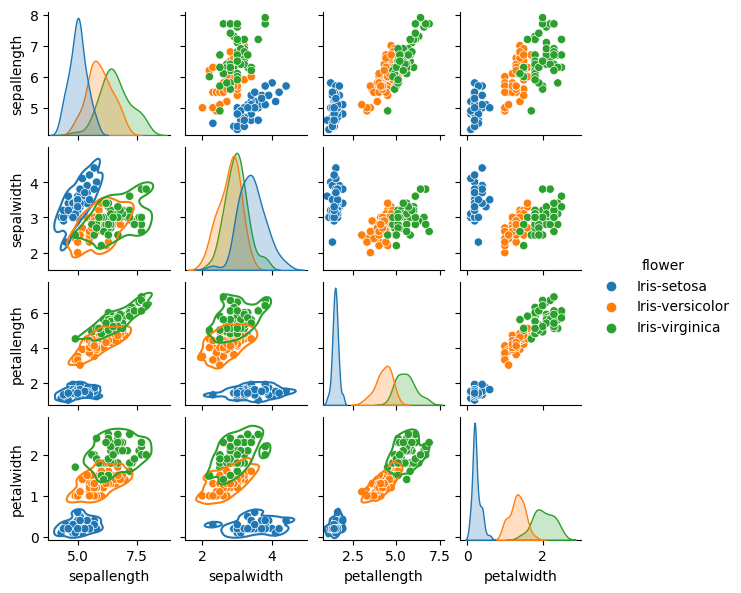

In [9]:
raw.sides

### Brainer Class

In [10]:
from __future__ import annotations

class PolyCellNet(keras.Model):
    polyname : str
    def __init__(self, name, celltypes, jk, outivaction, output_size):
        self.polyname = name
        super(PolyCellNet, self).__init__()
        lay_list = []
        for n_lay in numpy.arange(jk.shape[0]):
            if jk[n_lay, :].sum() > 0: # THERE ARE NEURONS IN THIS LAYER!
                tissue_list = []
                for celltype in numpy.arange(jk.shape[1]):
                    neuron_type = celltypes[celltype]
                    n_neuron = jk[n_lay, celltype]
                    if n_neuron > 0:
                        self.polyname +='l{}{}{}'.format(n_lay+1, neuron_type[:3], n_neuron)
                        tissue = keras.layers.Dense(n_neuron, activation=neuron_type)
                        tissue_list.append(tissue)
                n_tissues = len(tissue_list)
                if n_tissues == 0:
                    break
                if n_tissues == 1:
                    layer = tissue_list[0]
                elif n_tissues > 1:
                    layer = keras.layers.concatenate(tissue_list)
                
                lay_list.append(layer)
        n_layers = len(lay_list)
        if n_layers == 1:
            self.hidden = lay_list[0]
        elif n_layers > 1:
            self.hidden = keras.layers.concatenate(lay_list)
        self.out = keras.layers.Dense(output_size, activation=outivaction)

    def call(self, inputs):
        x = self.hidden(inputs)
        return self.out(x)
    
    def relevance(self, X, features, relevant_features):
        Ye = self.predict(X, verbose=0)
        relevance_dict = {}
        for feature in features:
            X_relevance = numpy.copy(X)
            X_relevance[:, numpy.array(features) == feature] = 0.0
            Ye_relevance = self.predict(X_relevance, verbose=0)
            Y_relevance = (Ye - Ye_relevance)**2
            feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
            relevance_dict[feature] = feature_relevance
        s_relevance = pandas.Series(relevance_dict)
        s_relevance_norm = s_relevance/s_relevance.max()
        s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
        selected_features = list(s_relevance_norm.index.values)
        selected_relevance = list(100.0*s_relevance_norm.values)
        return selected_features, selected_relevance

class Brain:
    name = None
    cfg : Config
    def __init__(self, name : str, cube : CleanCube, tix, vix, jk : numpy.ndarray, cfg : Config, strategy : tensorflow.distribute.MirroredStrategy):
        self.name = name
        self.cfg = cfg
        with strategy.scope():
            # Start Optimizers Inside Scope
            _optimizers = {'adagrad': tensorflow.keras.optimizers.Adagrad(learning_rate=self.cfg.learning_rate),
                          'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=self.cfg.learning_rate),
                          'adam': tensorflow.keras.optimizers.Adam(learning_rate=self.cfg.learning_rate)}
            # Declare, Compile & Fit WrapperPolyCell
            celltypes = self.cfg.activations
            network = PolyCellNet(self.name+'full', celltypes, jk, self.cfg.outivaction, cube.Y_scaled[tix].shape[1])

            # Compile
            scorer_name = self.cfg.scorer.lower()
            val_scorer_name = 'val_{}'.format(scorer_name)
            network.compile(optimizer=_optimizers[self.cfg.optimizer], loss='mse', metrics=[self.cfg.scorer])

            # Fit
            X = cube.X_scaled[tix]
            Y = cube.Y_scaled[tix]
            Xv = cube.X_scaled[vix]
            Yv = cube.Y_scaled[vix]
            es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.cfg.patience, restore_best_weights=True)
            es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=scorer_name, mode=self.cfg.scorer_mode, patience=self.cfg.patience, min_delta=self.cfg.neuron_gain)
            es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_scorer_name, mode=self.cfg.scorer_mode, patience=self.cfg.patience, min_delta=self.cfg.neuron_gain)
            es_callbacks = [es_loss, es_metric, es_val_metric]

            history = network.fit(X, Y, validation_data=(Xv, Yv), batch_size=X.shape[0], epochs=self.cfg.epochs_per_patience*self.cfg.patience, verbose=0, callbacks=es_callbacks)
            # network.summary()

            # UNPACK TRAINING RESULTS
            # network_loss = history.history['loss'][-1]
            # network_val_loss = history.history['val_loss'][-1]
            scorer_val = history.history[scorer_name][-1]
            val_scorer_val = history.history[val_scorer_name][-1]
            scorer_delta = 100.0*(1 - val_scorer_val/scorer_val)
            scorer_sign_str = '+' if numpy.sign(scorer_delta) >= 0 else ''
            r2_train = r2_score(Y, network.predict(X, verbose=0))
            r2_val = r2_score(Yv, network.predict(Xv, verbose=0))
            r2_delta = 100.0*(r2_val/r2_train - 1.0)
            r2_sign_str = '+' if numpy.sign(r2_delta) >= 0 else ''
            n_epochs = len(history.history['val_loss'])

            # CALCULATE VARIABLE RELEVANCE
            # Y_est = my_net.predict(X_scaled, verbose=0)
            # relevance_dict = {}
            # for feature in my_vars:
            #     X_relevance = numpy.copy(X_scaled)
            #     X_relevance[:, my_vars == feature] = 0.0
            #     Y_est_relevance = my_net.predict(X_relevance, verbose=0)
            #     Y_relevance = (Y_est - Y_est_relevance)**2
            #     feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
            #     relevance_dict[feature] = feature_relevance
            # s_relevance = pandas.Series(relevance_dict)
            # s_relevance_norm = s_relevance/s_relevance.max()
            # s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
            # selected_features = list(s_relevance_norm.index.values)
            # selected_relevance = list(100.0*s_relevance_norm.values)
            selected_features, selected_relevance = network.relevance(cube.X_scaled, cube.features, self.cfg.relevant_features)

            print(f"{network.polyname} > epoch:{n_epochs} [val/train] score {val_scorer_val:.3f}/{scorer_val:.3f} {scorer_sign_str}{scorer_delta:.0f}% r2 {r2_val:.3f}/{r2_train:.3f} {r2_sign_str}{r2_delta:.0f}% {selected_features}~{selected_relevance}")



class Brainer(dict[Brain]):
    cfg : Config
    still_searching : bool = True
    scorer_mode : str = None
    best_brain_name : str = None
    best_metric : float = None
    best_metric_val : float = None
    metric_bound : float = None
    outivaction: str = None

    def __init__(self, cfg : Config):
        self.cfg = cfg
        # BRAINER LOCAL CONFIGS
        if self.cfg.scorer == 'mse':
            self.scorer_mode = 'min'
            self.best_metric = 1.0
            self.best_metric_val = 1.0
            self.metric_bound = 1000.0
            self.outivaction = 'linear'
        elif self.cfg.scorer in ['precision', 'recall', 'accuracy']:
            self.scorer_mode = 'max'
            self.best_metric = 0.0
            self.best_metric_val = 0.0
            self.metric_bound = 0.0
            self.outivaction = 'sigmoid'
        else:
            self.scorer_mode = 'min'
            self.best_metric = 1.0
            self.best_metric_val = 1.0
            self.metric_bound = 1000.0
            self.outivaction = 'linear'
    
    def solve(self, cube : CleanCube) -> Brain:
        # result_list = []
        print('Finding the best brain for cube...')
        n_activations = len(self.cfg.activations)
        brainspace = numpy.zeros((n_activations, self.cfg.max_layers, n_activations), dtype=int) # BrainPoint_i, Layer_j, Activation_k Tensor
        brainspace[:, 0, :] = numpy.identity(n_activations)
        round = 1
        strategy = tensorflow.distribute.MirroredStrategy()
        while self.still_searching:
            print(f"ROUND {round}")
            for jk in brainspace:
                print('{}'.format(jk))
                fold = 1
                # tix, vix : train & test iNDExES
                for tix, vix in cube.kfolder.split(cube.X, cube.sampler):
                    for optimizer in self.cfg.optimizers:
                        brain_name = f"{optimizer.lower()[:4]}{fold}f{cube.cfg.folds}"
                        brain_cfg = Config({})
                        brain_cfg.optimizer = optimizer
                        brain_cfg.activations = self.cfg.activations
                        brain_cfg.outivaction = self.outivaction
                        brain_cfg.scorer = self.cfg.scorer
                        brain_cfg.scorer_mode = self.scorer_mode
                        brain_cfg.patience = self.cfg.patience
                        brain_cfg.epochs_per_patience = self.cfg.epochs_per_patience
                        brain_cfg.neuron_gain = self.cfg.neuron_gain
                        brain_cfg.learning_rate = self.cfg.learning_rate
                        brain_cfg.relevant_features = self.cfg.relevant_features
                        brain = Brain(brain_name, cube, tix, vix, jk, brain_cfg, strategy)
                    fold += 1
            round += 1

            if round > 1:
                break

        return self

brainer = Brainer(brainer_cfg)
brain = brainer.solve(cube)

Finding the best brain for cube...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
ROUND 1
[[1 0 0]
 [0 0 0]
 [0 0 0]]
adag1f20fulll1lin1 > epoch:239 [val/train] score 0.123/0.142 +14% r2 0.877/0.858 +2% ['petalwidth', 'sepallength', 'sepalwidth']~[100.0, 71.45475547952591, 60.63522356698851]
adam1f20fulll1lin1 > epoch:120 [val/train] score 0.020/0.025 +19% r2 0.980/0.975 +0% ['Iris-setosa', 'sepallength', 'petalwidth']~[100.0, 61.56495967975493, 43.56713259426589]
adag2f20fulll1lin1 > epoch:121 [val/train] score 0.050/0.066 +25% r2 0.949/0.934 +2% ['Iris-setosa', 'petalwidth', 'sepallength']~[100.0, 61.06802467670265, 44.560282008100124]
adam2f20fulll1lin1 > epoch:93 [val/train] score 0.060/0.050 -20% r2 0.938/0.950 -1% ['petalwidth', 'sepallength', 'sepalwidth']~[100.0, 33.86529041089409, 12.19721756550477]


In [ ]:
# TRAINING INTERNAL PARAMETERS AND LOCAL VARIABLES
while still_searching:
    for pattern in current_configurations:
        print('CONFIG:\n{}'.format(pattern))
        ix_fold = 1
        for train_index, test_index in kfolder.split(X_scaled, Y_sample):
            print('FOLD: {}/{}'.format(ix_fold, fold_number))

            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y_scaled[train_index], Y_scaled[test_index]
            for optimizer in my_optimizers:
                # # Open a strategy scope and create/restore the model
                # with strategy.scope():
                #     # DECLARE OPTIMIZERS INSIDE SCOPE
                #     _optimizers = {'adagrad': tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate),
                #                    'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate),
                #                    'adam': tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)}
                #     # DECLARE NET
                #     inputs = keras.Input(shape=(X_train.shape[1], ))
                #     hidden_layer_list = []
                #     net_name = ''
                #     for inner_layer in numpy.arange(len(pattern)):
                #         for ix_activation in numpy.arange(len(pattern)):
                #             f_activation = hidden_activations[ix_activation]
                #             n_neuron = pattern[ix_activation]
                #             if n_neuron > 0:
                #                 temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                #                 hidden_layer_list.append(temp_hidden_layer)
                #                 net_name += '{}{}'.format(f_activation, n_neuron)
                #     if len(hidden_layer_list) > 1:
                #         hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                #     else:
                #         hidden = hidden_layer_list[0]
                #     outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                #     model_name = '{}_{}_F{}_WRAPPER'.format(net_name.upper(), optimizer.upper(), ix_fold)
                #     my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # # COMPILE NET
                # metric_name = my_metric.lower()
                # val_metric_name = 'val_{}'.format(metric_name)
                # my_net.compile(optimizer=_optimizers[optimizer], loss='mse', metrics=[my_metric])
                # es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                # es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                # es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                #                                                          patience=n_k_folds*my_patience, min_delta=min_improvement)

                # # FIT WRAPPER
                # history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0],
                #                     epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # CALCULATE VARIABLE RELEVANCE
                Y_est = my_net.predict(X_scaled, verbose=0)
                relevance_dict = {}
                for feature in my_vars:
                    X_relevance = numpy.copy(X_scaled)
                    X_relevance[:, my_vars == feature] = 0.0
                    Y_est_relevance = my_net.predict(X_relevance, verbose=0)
                    Y_relevance = (Y_est - Y_est_relevance)**2
                    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
                    relevance_dict[feature] = feature_relevance
                s_relevance = pandas.Series(relevance_dict)
                s_relevance_norm = s_relevance/s_relevance.max()
                s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
                selected_features = list(s_relevance_norm.index.values)
                selected_relevance = list(100.0*s_relevance_norm.values)

                # FINAL NET
                with strategy.scope():
                    inputs = keras.Input(shape=(len(selected_features), ))
                    hidden_layer_list = []
                    net_name = ''
                    for ix_activation in numpy.arange(len(net_config)):
                        f_activation = hidden_activations[ix_activation]
                        n_neuron = net_config[ix_activation]
                        if n_neuron > 0:
                            temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                            hidden_layer_list.append(temp_hidden_layer)
                            net_name += '{}{}'.format(f_activation, n_neuron)
                    if len(hidden_layer_list) > 1:
                        hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                    else:
                        hidden = hidden_layer_list[0]
                    outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                    model_name = '{}_{}_F{}'.format(net_name.upper(), optimizer.upper(), ix_fold)
                    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                ix_relevant = dfn['X'].columns.get_level_values(1).isin(selected_features)
                history = my_net.fit(X_train[:, ix_relevant], Y_train, validation_data=(X_test[:, ix_relevant], Y_test), batch_size=X_train.shape[0],
                                    epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if my_mode == 'max':
                    is_best = ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement))
                elif my_mode == 'min':
                    is_best = ((metric_val < best_metric - min_improvement) & (val_metric_val <= best_metric_val)) | ((metric_val <= best_metric) & (val_metric_val < best_metric_val - min_improvement))

                if is_best:
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_config = net_config
                    best_features = selected_features
                    best_relevance = selected_relevance
                    best_net = my_net
                    best_neurons = net_config.sum()
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'net_config': net_config, 'neurons': net_config.sum(), 'fold': ix_fold, 'features': selected_features, 'relevance': selected_relevance, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)
                if is_best or print_anyway:
                    print('{}_{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.2f} {}: {:.2f} {}'.format(model_name,'_'.join(selected_features), n_epochs, model_loss, model_val_loss, metric_name, metric_val, val_metric_name, val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                if my_mode == 'max':
                    maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                elif my_mode == 'min':
                    maximized_metrics = (val_metric_val == 0.0) & (metric_val == 0.0)

                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            ix_fold += 1

        if maximized_metrics:
            break

    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    total_neurons = net_config.sum()

    if total_neurons > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < total_neurons:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(total_neurons, metric_name))
            break
    
    # CALCULATE CONFIG BOUND
    df_results = pandas.DataFrame(result_list)
    ix_config = numpy.array([numpy.linalg.norm(best_config - x) for x in df_results.net_config]) == 0.0
    if my_mode == 'max':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].min()
    elif my_mode == 'min':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].max()

    # TEST IF LOWER BOUND IMPROVED
    bound_didnt_improve = False
    if total_neurons > 1:
        neuron_gain = 0.0
        if my_mode == 'max':
            if bound_est > metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = bound_est/metric_bound - 1.0
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break
        elif my_mode == 'min':
            if bound_est < metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = 1.0 - bound_est/metric_bound
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break

    else:
        print('BEST CONFIG {} & best quality for {}: {:.2f}'.format(best_config, best_optimizer.upper(), bound_est))
    
    metric_bound = bound_est

    # ALTER CONFIG FROM BEST CONFIG IF NEEDED
    if maximized_metrics or dont_need_extra_neurons or bound_didnt_improve:
        still_searching = False
    else:
        current_configurations = best_config + search_vector

BREEDING THE BEST BRAIN!

CONFIG:
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
FOLD: 1/5


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
if bound_didnt_improve and rollback_on_no_bound_gain:
    best_row = df_results[(df_results.neurons == best_config.sum() - 1) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_config = best_row['net_config'].values[0]
    best_features = best_row['features'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]

In [ ]:
# PREDICT
ix_best_features = dfn['X'].columns.isin(best_features, level=1)
Y_est_scaled = best_net.predict(X_scaled[:, ix_best_features], verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)

# PLOT Y Vs YEST
df_result = pandas.DataFrame(index=df.index)
df_result['Y'] = Y
df_result['Y_est'] = Y_est
df_result['r'] = df_result['Y_est'] - df_result['Y']
df_result['rabs'] = df_result['r'].abs()
df_result = df_result.join(df.loc[:, df.columns != reg_col])

df_result

,Y,Y_est,r,rabs,sepallength,sepalwidth,petalwidth,flower
0,1.4,1.497004,0.097004,0.097004,5.1,3.5,0.2,Iris-setosa
1,1.4,1.497004,0.097004,0.097004,4.9,3.0,0.2,Iris-setosa
2,1.3,1.497004,0.197004,0.197004,4.7,3.2,0.2,Iris-setosa
3,1.5,1.497004,-0.002996,0.002996,4.6,3.1,0.2,Iris-setosa
4,1.4,1.497004,0.097004,0.097004,5.0,3.6,0.2,Iris-setosa
...,...,...,...,...,...,...,...,...
145,5.2,5.681056,0.481056,0.481056,6.7,3.0,2.3,Iris-virginica
146,5.0,5.573483,0.573483,0.573483,6.3,2.5,1.9,Iris-virginica
147,5.2,5.607918,0.407918,0.407918,6.5,3.0,2.0,Iris-virginica
148,5.4,5.681056,0.281056,0.281056,6.2,3.4,2.3,Iris-virginica


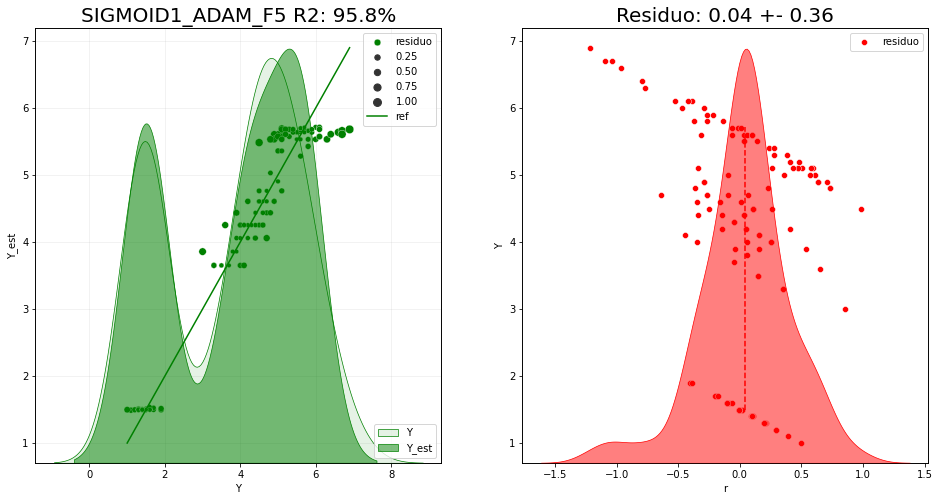

In [ ]:
# STABLE RESIDUAL PLOT
r_mean = df_result.r.median()
r_std = df_result.r.std()
r2 = r2_score(df_result.Y.to_numpy(), df_result.Y_est.to_numpy())

fig = pyplot.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
lines = seaborn.scatterplot(data=df_result, x='Y', y='Y_est', size='rabs', ax=ax, label='residuo', color='green')
_ = ax.plot([df_result.Y.min(), df_result.Y.max()], [df_result.Y.min(), df_result.Y.max()], color='green', label='ref')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(best_net_name,100.0*r2), size=20)
ax2 = ax.twinx()
_ = seaborn.kdeplot(data=df_result, x='Y', ax=ax2, label='Y', color='green', fill=True, alpha=0.1, linewidth=0.7)
_ = seaborn.kdeplot(data=df_result, x='Y_est', ax=ax2, label='Y_est', color='green', fill=True, alpha=0.5, linewidth=0.7)
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
_ = ax.legend(loc='upper right')
_ = ax2.legend(loc='lower right')
ax3 = fig.add_subplot(122)
_ = seaborn.scatterplot(data=df_result, x='r', y='Y', ax=ax3, label='residuo', color='red')
ax4 = ax3.twinx()
_ = seaborn.kdeplot(data=df_result, x='r', ax=ax4, label='residuo', color='red', fill=True, alpha=0.5, linewidth=0.7)
_ = ax4.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title('Residuo: {:.2f} +- {:.2f}'.format(r_mean, r_std), size=20)
_ = ax3.plot([r_mean, r_mean], [df_result.Y_est.min(), df_result.Y_est.max()], '--', color='red')

In [ ]:
df_result.Y_est.max()

5.7117724

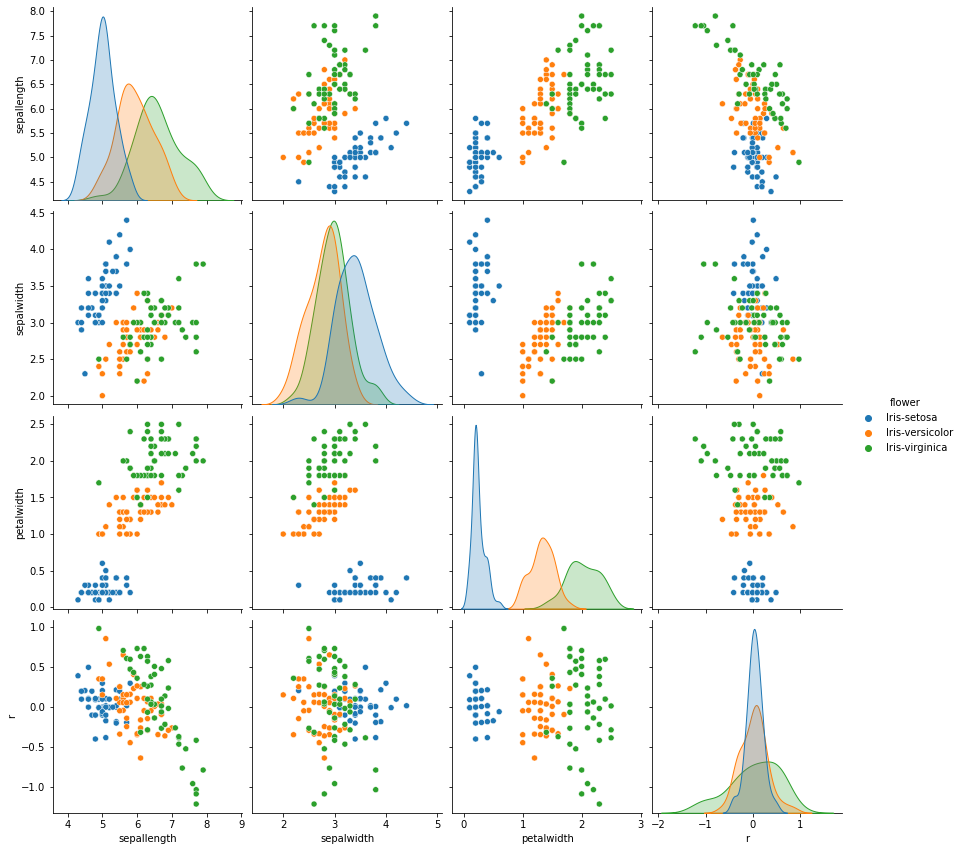

In [ ]:
# SCATTER PLOT
resplot_var = list(df.columns[df.columns != reg_col])
resplot_var.append('r')
g2 = seaborn.pairplot(df_result[resplot_var], hue='flower', height=3, diag_kind='kde')
# _ = g2.map_lower(seaborn.kdeplot, levels=1, color=".2")